---
## 1. Import libraries

In [20]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set_theme() # set the default Seaborn style for graphics

---
## 2. Data cleaning

In [21]:
# Import dataset and check basic information
full_dataset = pd.read_csv('datasets/spotify_songs.csv')
print(full_dataset.shape)
full_dataset.info()

(32833, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  

From the printed `.info()` above, we can see that some of the song records in the `full_dataset` contain `NA` values in certain variable columns. Hence, we drop those song records from `full_dataset`.

In [22]:
# Apply the dropna() function to remove records with missing values
# Then check the information of the cleaned dataset
full_dataset.dropna(inplace=True)
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32828 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32828 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32828 non-null  int64  
 4   track_album_id            32828 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32828 non-null  object 
 7   playlist_name             32828 non-null  object 
 8   playlist_id               32828 non-null  object 
 9   playlist_genre            32828 non-null  object 
 10  playlist_subgenre         32828 non-null  object 
 11  danceability              32828 non-null  float64
 12  energy                    32828 non-null  float64
 13  key                       32828 non-null  int64  
 14  loudness   

Our goal is to predict the popularity of the songs using different variables as predictors.
In order to achieve this, we:
1. Analyse the `track_popularity` variable
2. Categorize the `track_popularity` score into 6 different categories.

       track_popularity
count      32828.000000
mean          42.483551
std           24.980476
min            0.000000
25%           24.000000
50%           45.000000
75%           62.000000
max          100.000000
track_popularity
0                   2698
1                    575
57                   541
60                   514
54                   514
                    ... 
97                    22
95                    15
96                     7
99                     4
100                    2
Name: count, Length: 101, dtype: int64


<Axes: >

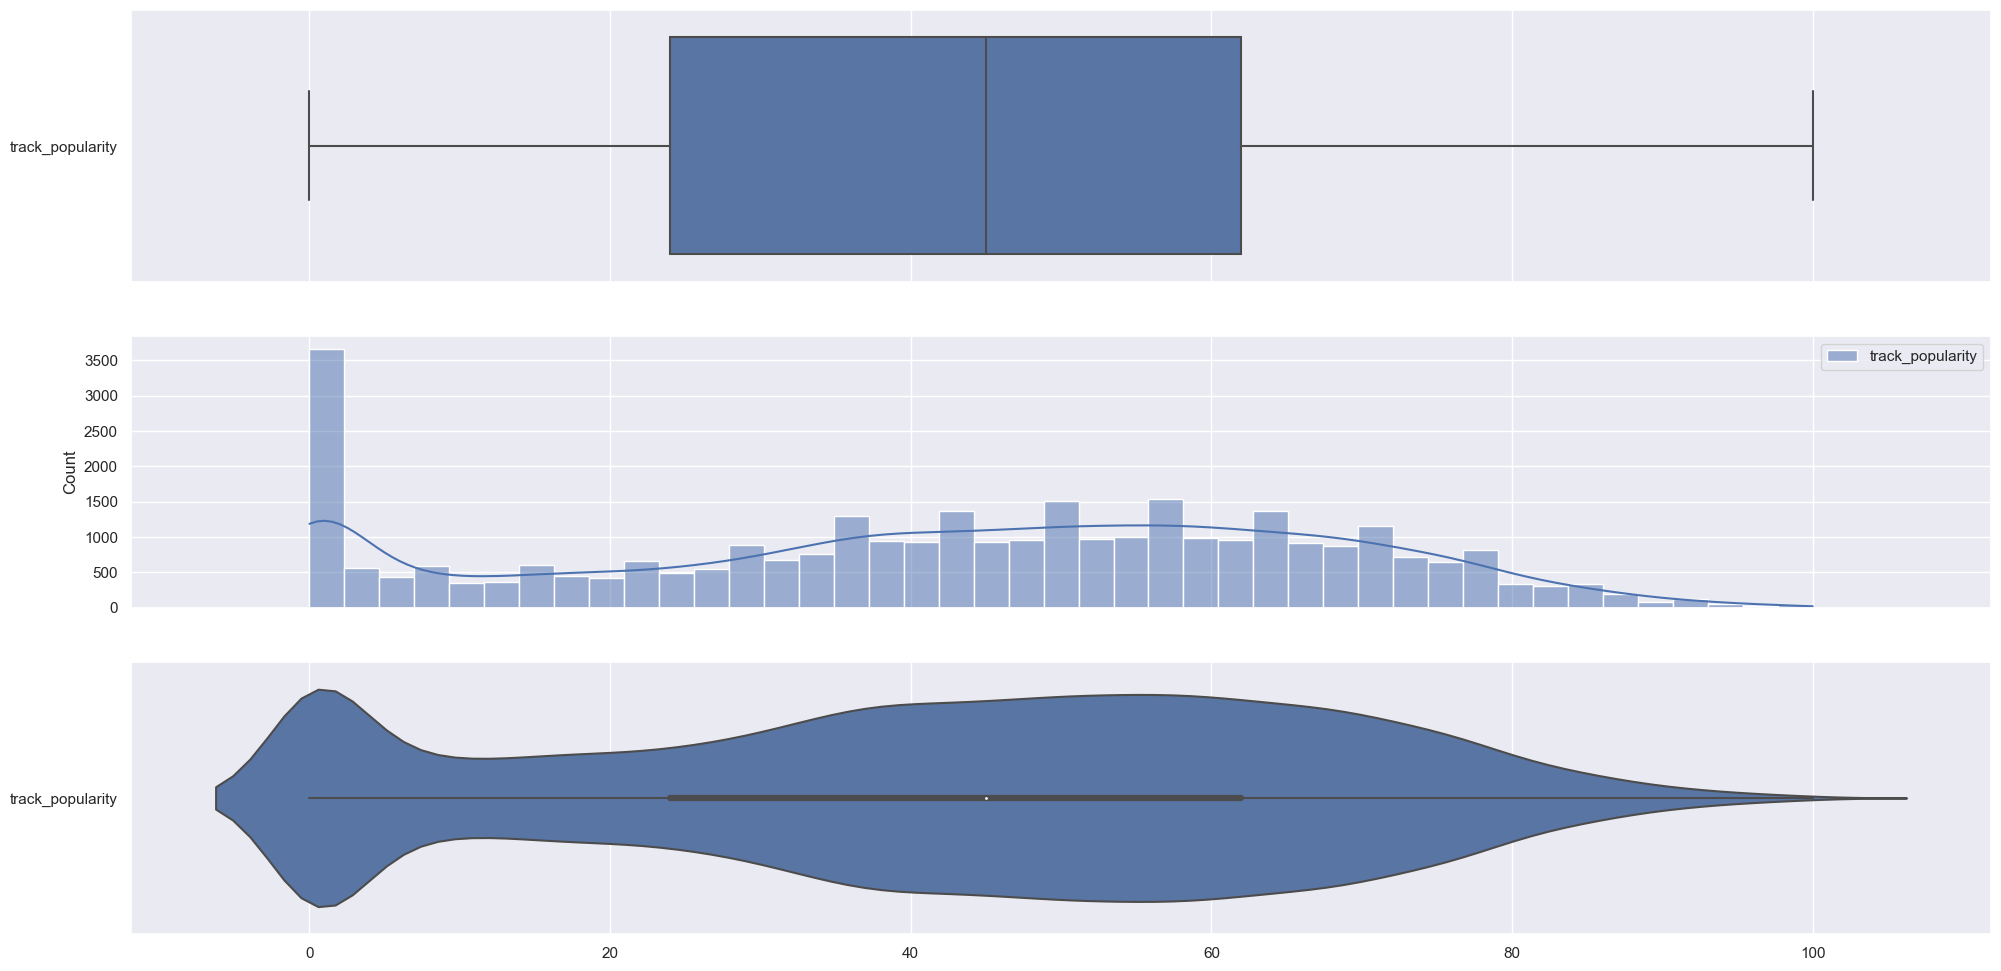

In [23]:
# Extract the track_popularity column and check its distribution
popularity = pd.DataFrame(full_dataset["track_popularity"])
print(popularity.describe())
print(popularity.value_counts())

f, axes = plt.subplots(3, 1, figsize=(24, 12), sharex=True)
sb.boxplot(data = popularity, orient = "h", ax=axes[0])
sb.histplot(data = popularity, kde = True, ax=axes[1])
sb.violinplot(data = popularity, orient = "h", ax=axes[2])

From the plots and `.value_counts()` above, we can see that there are unexpectedly high number of song records with `track_popularity <= 1`. In order to ensure the data is more normally distributed, we choose to remove those song records from our `full_dataset`.

Skewness of popularity: -0.23375042175196648

track_popularity
57     541
51     514
60     514
54     514
52     506
      ... 
97      22
95      15
96       7
99       4
100      2
Name: count, Length: 99, dtype: int64


<Axes: >

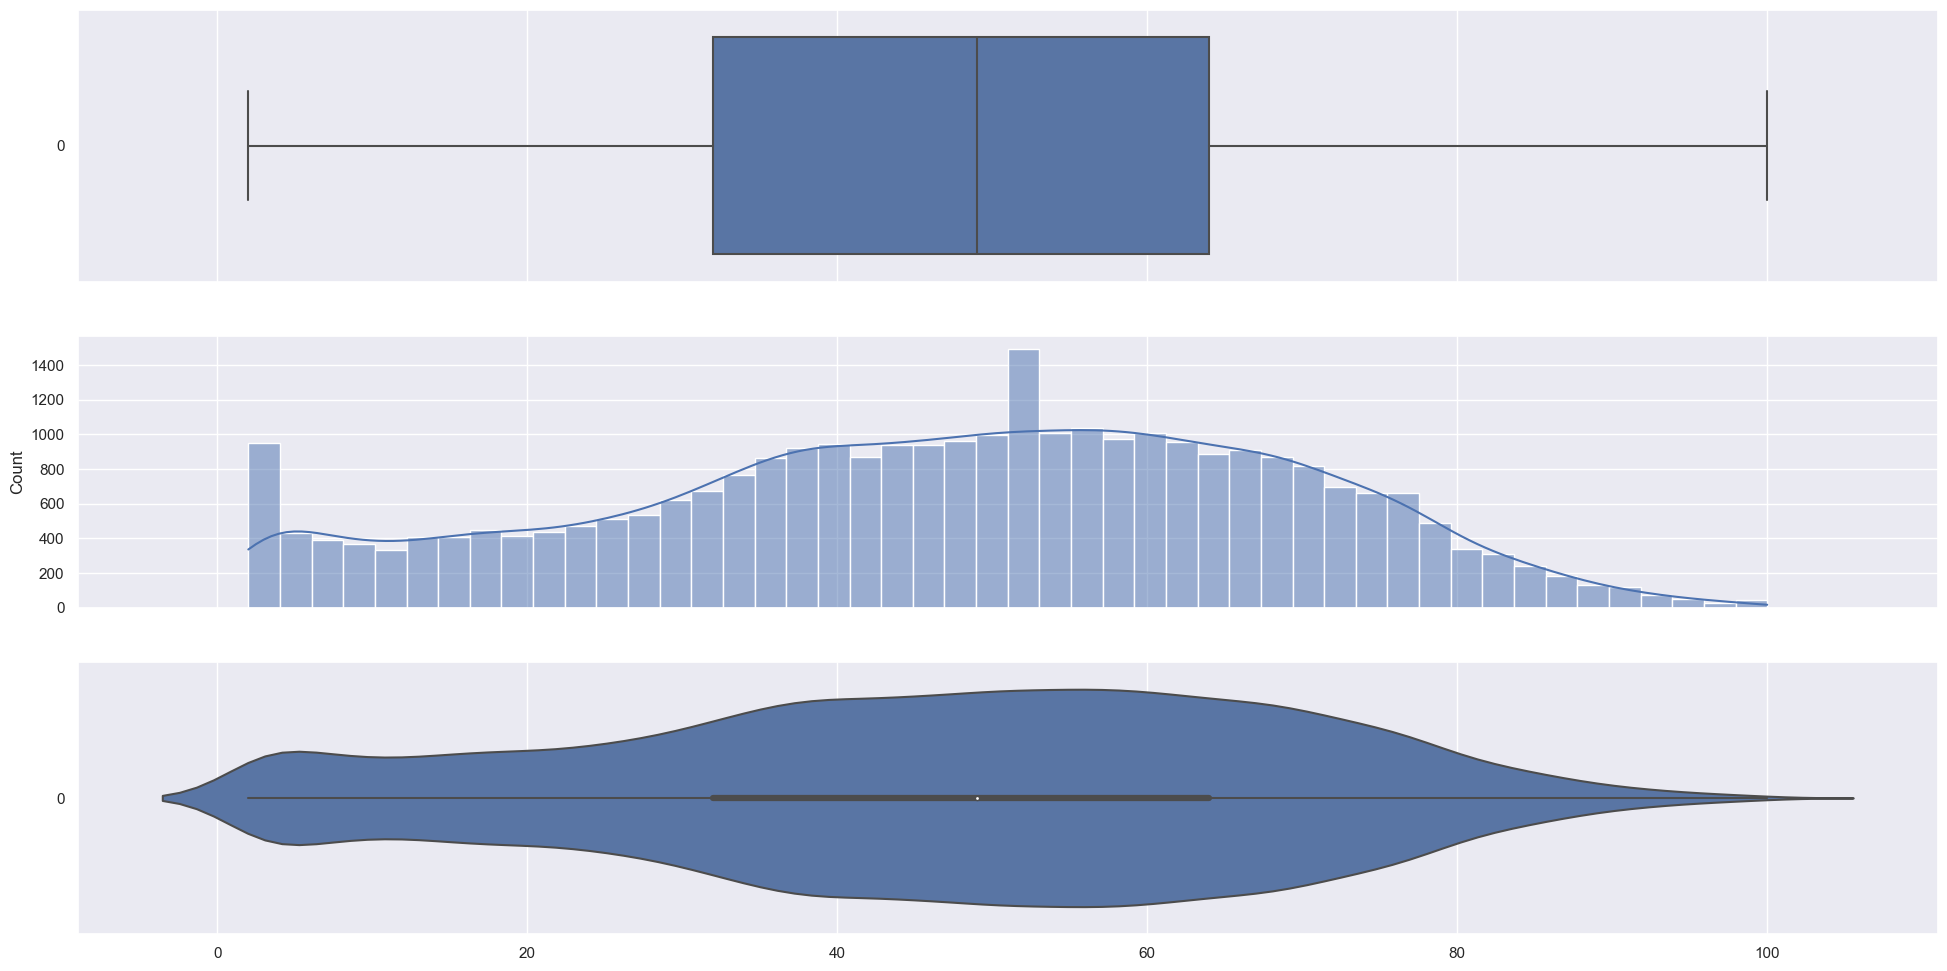

In [24]:
# Remove records whose value of track_popularity is lower than or equal to 1
full_dataset = full_dataset[full_dataset['track_popularity'] > 1]
popularity = full_dataset["track_popularity"]

# Check the skewness and distribution of the track_popularity column
from scipy.stats import skew

print("Skewness of popularity:", skew(popularity))
print()

print(popularity.value_counts())

f, axes = plt.subplots(3, 1, figsize=(24, 12), sharex=True)
sb.boxplot(data = popularity, orient = "h", ax=axes[0])
sb.histplot(data = popularity, kde = True, ax=axes[1])
sb.violinplot(data = popularity, orient = "h", ax=axes[2])

From the calculated skewness and plots above, we can clearly see that **`track_popularity` is similar to a normal distribution** if we discard the clustering phenomenon at the lower spectrum.

Thus, we can then divide `track_popularity` into **6 levels** -- `very_low`, `low`, `somewhat_low`, `somewhat_high`, `high`, and `very_high` -- using mean and standard deviation as the parameters to gauge.

In [25]:
# Calculate the mean and standard deviation of track_popularity
mean = popularity.mean()
std = popularity.std()

# Define the level divisions
very_low = mean - 2 * std
low = mean - std
medium = mean
high = mean + std
very_high = mean + 2 * std

# Create a new column "popularity_level" based on the level divisions
full_dataset["popularity_level"] = pd.cut(full_dataset["track_popularity"], bins=[0, very_low, low, medium, high, very_high, float('inf')], labels=["very_low", "low", "somewhat_low", "somewhat_high", "high", "very_high"])

# Check the distribution of popularity levels
popularity_level = pd.DataFrame(full_dataset["popularity_level"].value_counts(sort=False), columns=["count"])
popularity_level["density"] = popularity_level["count"] / len(full_dataset)
popularity_level

,count,density
popularity_level,,
very_low,708,0.023955
low,4591,0.155338
somewhat_low,8834,0.298900
somewhat_high,10145,0.343258
high,5025,0.170022
very_high,252,0.008526


We then save the cleaned dataset to a new CSV file named `clean_dataset.csv`

In [26]:
#Save the extracted and cleaned dataset into a separate file named clean_dataset.csv
full_dataset.to_csv('datasets/cleaned_dataset.csv', index=False)

---
## 3. Data randomization

The current sample size is over *30k*, and we choose to reduce it to *5k* by random sampling method and save the randomized dataset to a new CSV file named `random_sampled_dataset.csv`

In [27]:
sampled_dataset = full_dataset.sample(n=5000, random_state=29) # Use a random seed of 29 for reproducibility
sampled_dataset.to_csv('datasets/random_sampled_dataset.csv', index=False)
print("Dimensions of sampled dataset:", sampled_dataset.shape)
print()
print(sampled_dataset["popularity_level"].value_counts(sort=False) / len(sampled_dataset))

Dimensions of sampled dataset: (5000, 24)

popularity_level
very_low         0.0230
low              0.1458
somewhat_low     0.3060
somewhat_high    0.3446
high             0.1684
very_high        0.0122
Name: count, dtype: float64


---
## 4. EDA and Visualisation analysis on sampled dataset

### EDA and Visualisation analysis on *numeric* variables

We first examine the *numeric* variables and their relationships with `track_popularity`, the original numeric column of `popularity_level`.

                  track_popularity  danceability    energy  speechiness  \
track_popularity          1.000000      0.066074 -0.118293     0.003669   
danceability              0.066074      1.000000 -0.094669     0.205571   
energy                   -0.118293     -0.094669  1.000000    -0.037833   
speechiness               0.003669      0.205571 -0.037833     1.000000   
instrumentalness         -0.159500     -0.029994  0.020582    -0.110604   
liveness                 -0.051623     -0.129062  0.172802     0.019553   
valence                   0.042973      0.330706  0.160759     0.076242   
tempo                     0.003367     -0.165693  0.145218     0.052914   
duration_ms              -0.101557     -0.089798 -0.012939    -0.077723   

                  instrumentalness  liveness   valence     tempo  duration_ms  
track_popularity         -0.159500 -0.051623  0.042973  0.003367    -0.101557  
danceability             -0.029994 -0.129062  0.330706 -0.165693    -0.089798  
energy   

<Axes: >

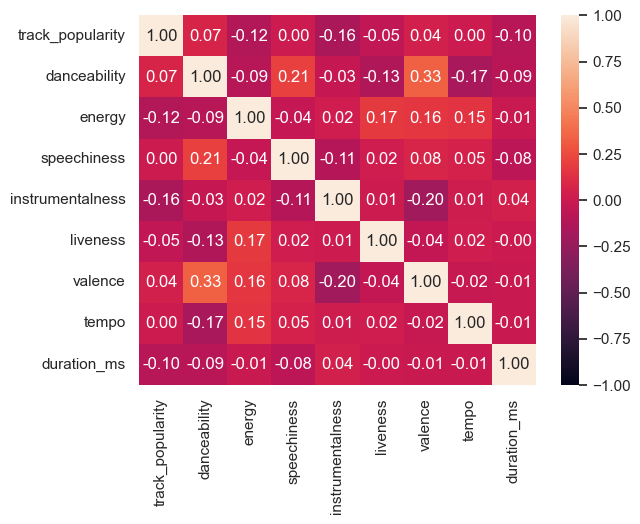

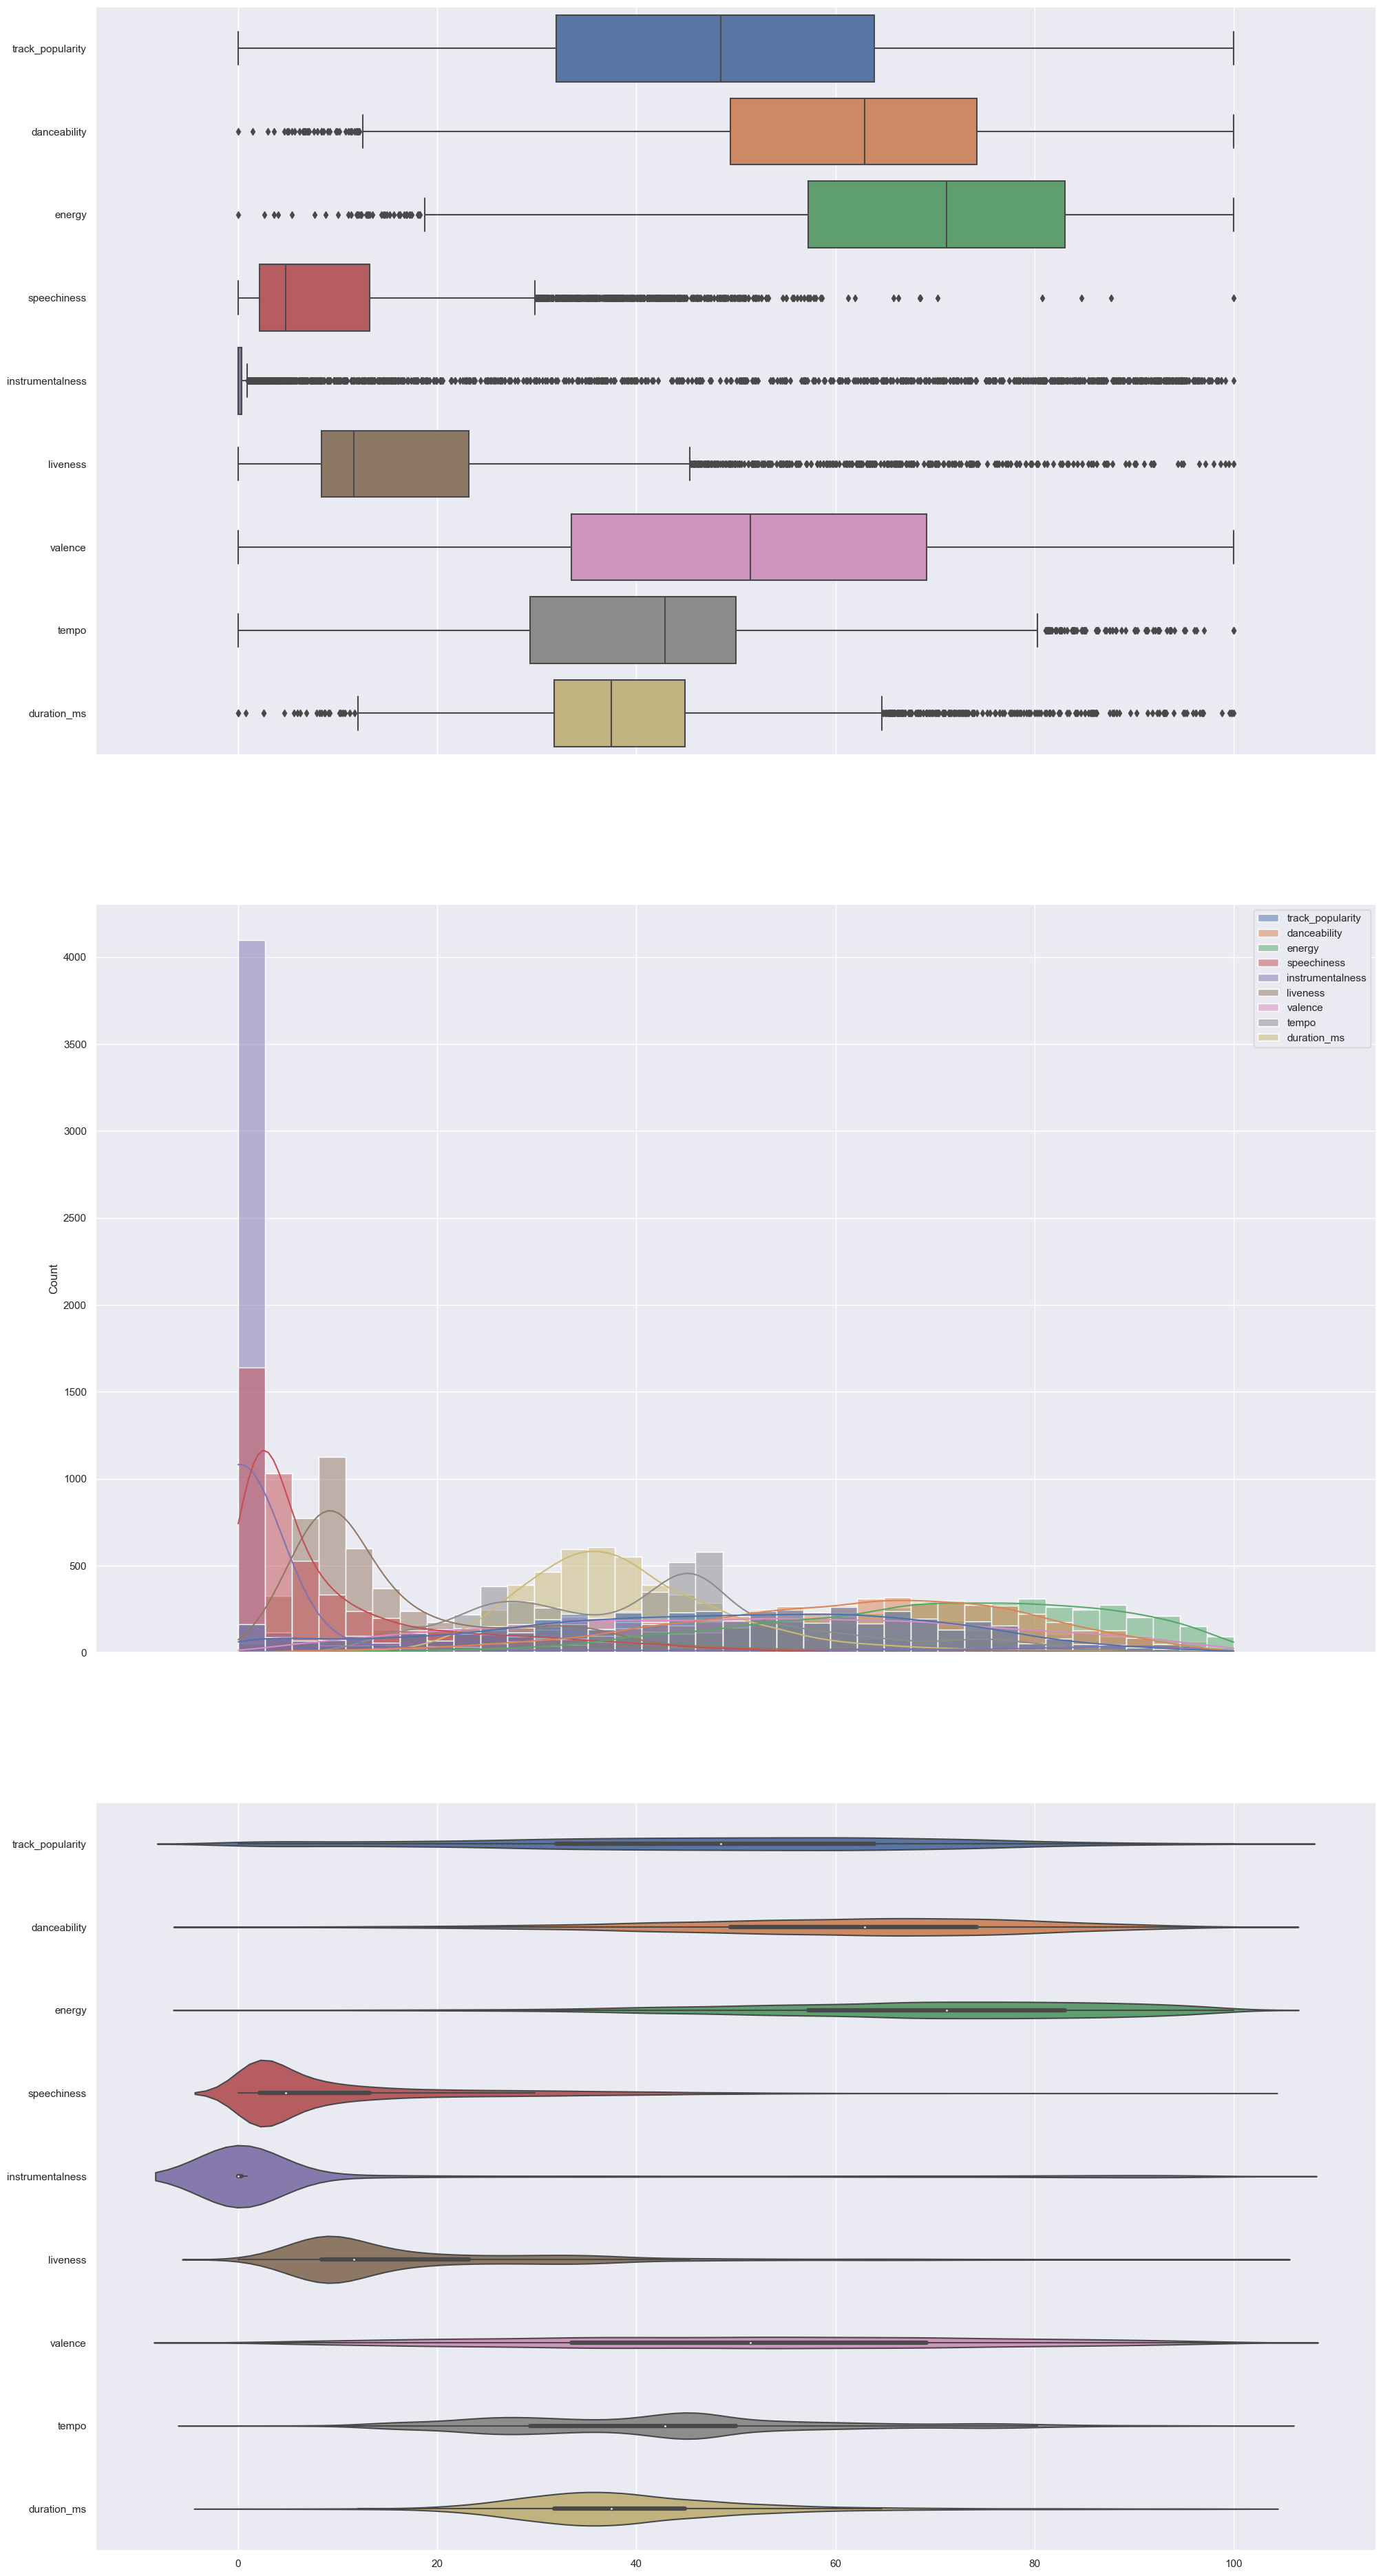

In [28]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min()) * 100

# Store the numeric column names in a list
numeric_columns = ["track_popularity", "danceability", "energy", "speechiness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"]

# Plot the correlation between the numeric columns as a heatmap
print(sampled_dataset[numeric_columns].corr())
sb.heatmap(sampled_dataset[numeric_columns].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

# Plot the distributions of the numeric columns
f, axes = plt.subplots(3, 1, figsize=(24, 48), sharex=True)
sb.boxplot(data = sampled_dataset[numeric_columns].apply(min_max_normalize), orient = "h", ax=axes[0])
sb.histplot(data = sampled_dataset[numeric_columns].apply(min_max_normalize), kde = True, ax=axes[1])
sb.violinplot(data = sampled_dataset[numeric_columns].apply(min_max_normalize), orient = "h", ax=axes[2])

From the heatmap, we find 4 variables with the highest correlations with variable `track_popularity` (Highest correlation is determined by the highest **absolute values** of different variables with `track_popularity`).

The 4 variables are: `instrumentalness` (corr = -0.16), `energy` (corr = -0.12), `duration_ms` (corr = -0.10), `danceability` (corr = 0.07)

                  track_popularity  instrumentalness    energy  duration_ms  \
track_popularity          1.000000         -0.159500 -0.118293    -0.101557   
instrumentalness         -0.159500          1.000000  0.020582     0.044864   
energy                   -0.118293          0.020582  1.000000    -0.012939   
duration_ms              -0.101557          0.044864 -0.012939     1.000000   
danceability              0.066074         -0.029994 -0.094669    -0.089798   

                  danceability  
track_popularity      0.066074  
instrumentalness     -0.029994  
energy               -0.094669  
duration_ms          -0.089798  
danceability          1.000000  


<Axes: >

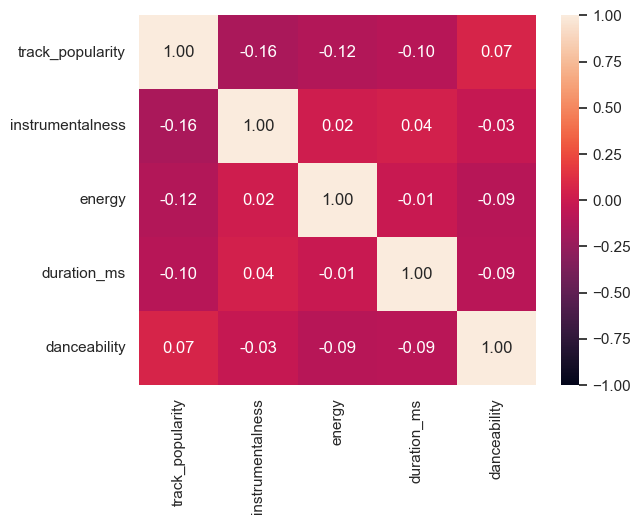

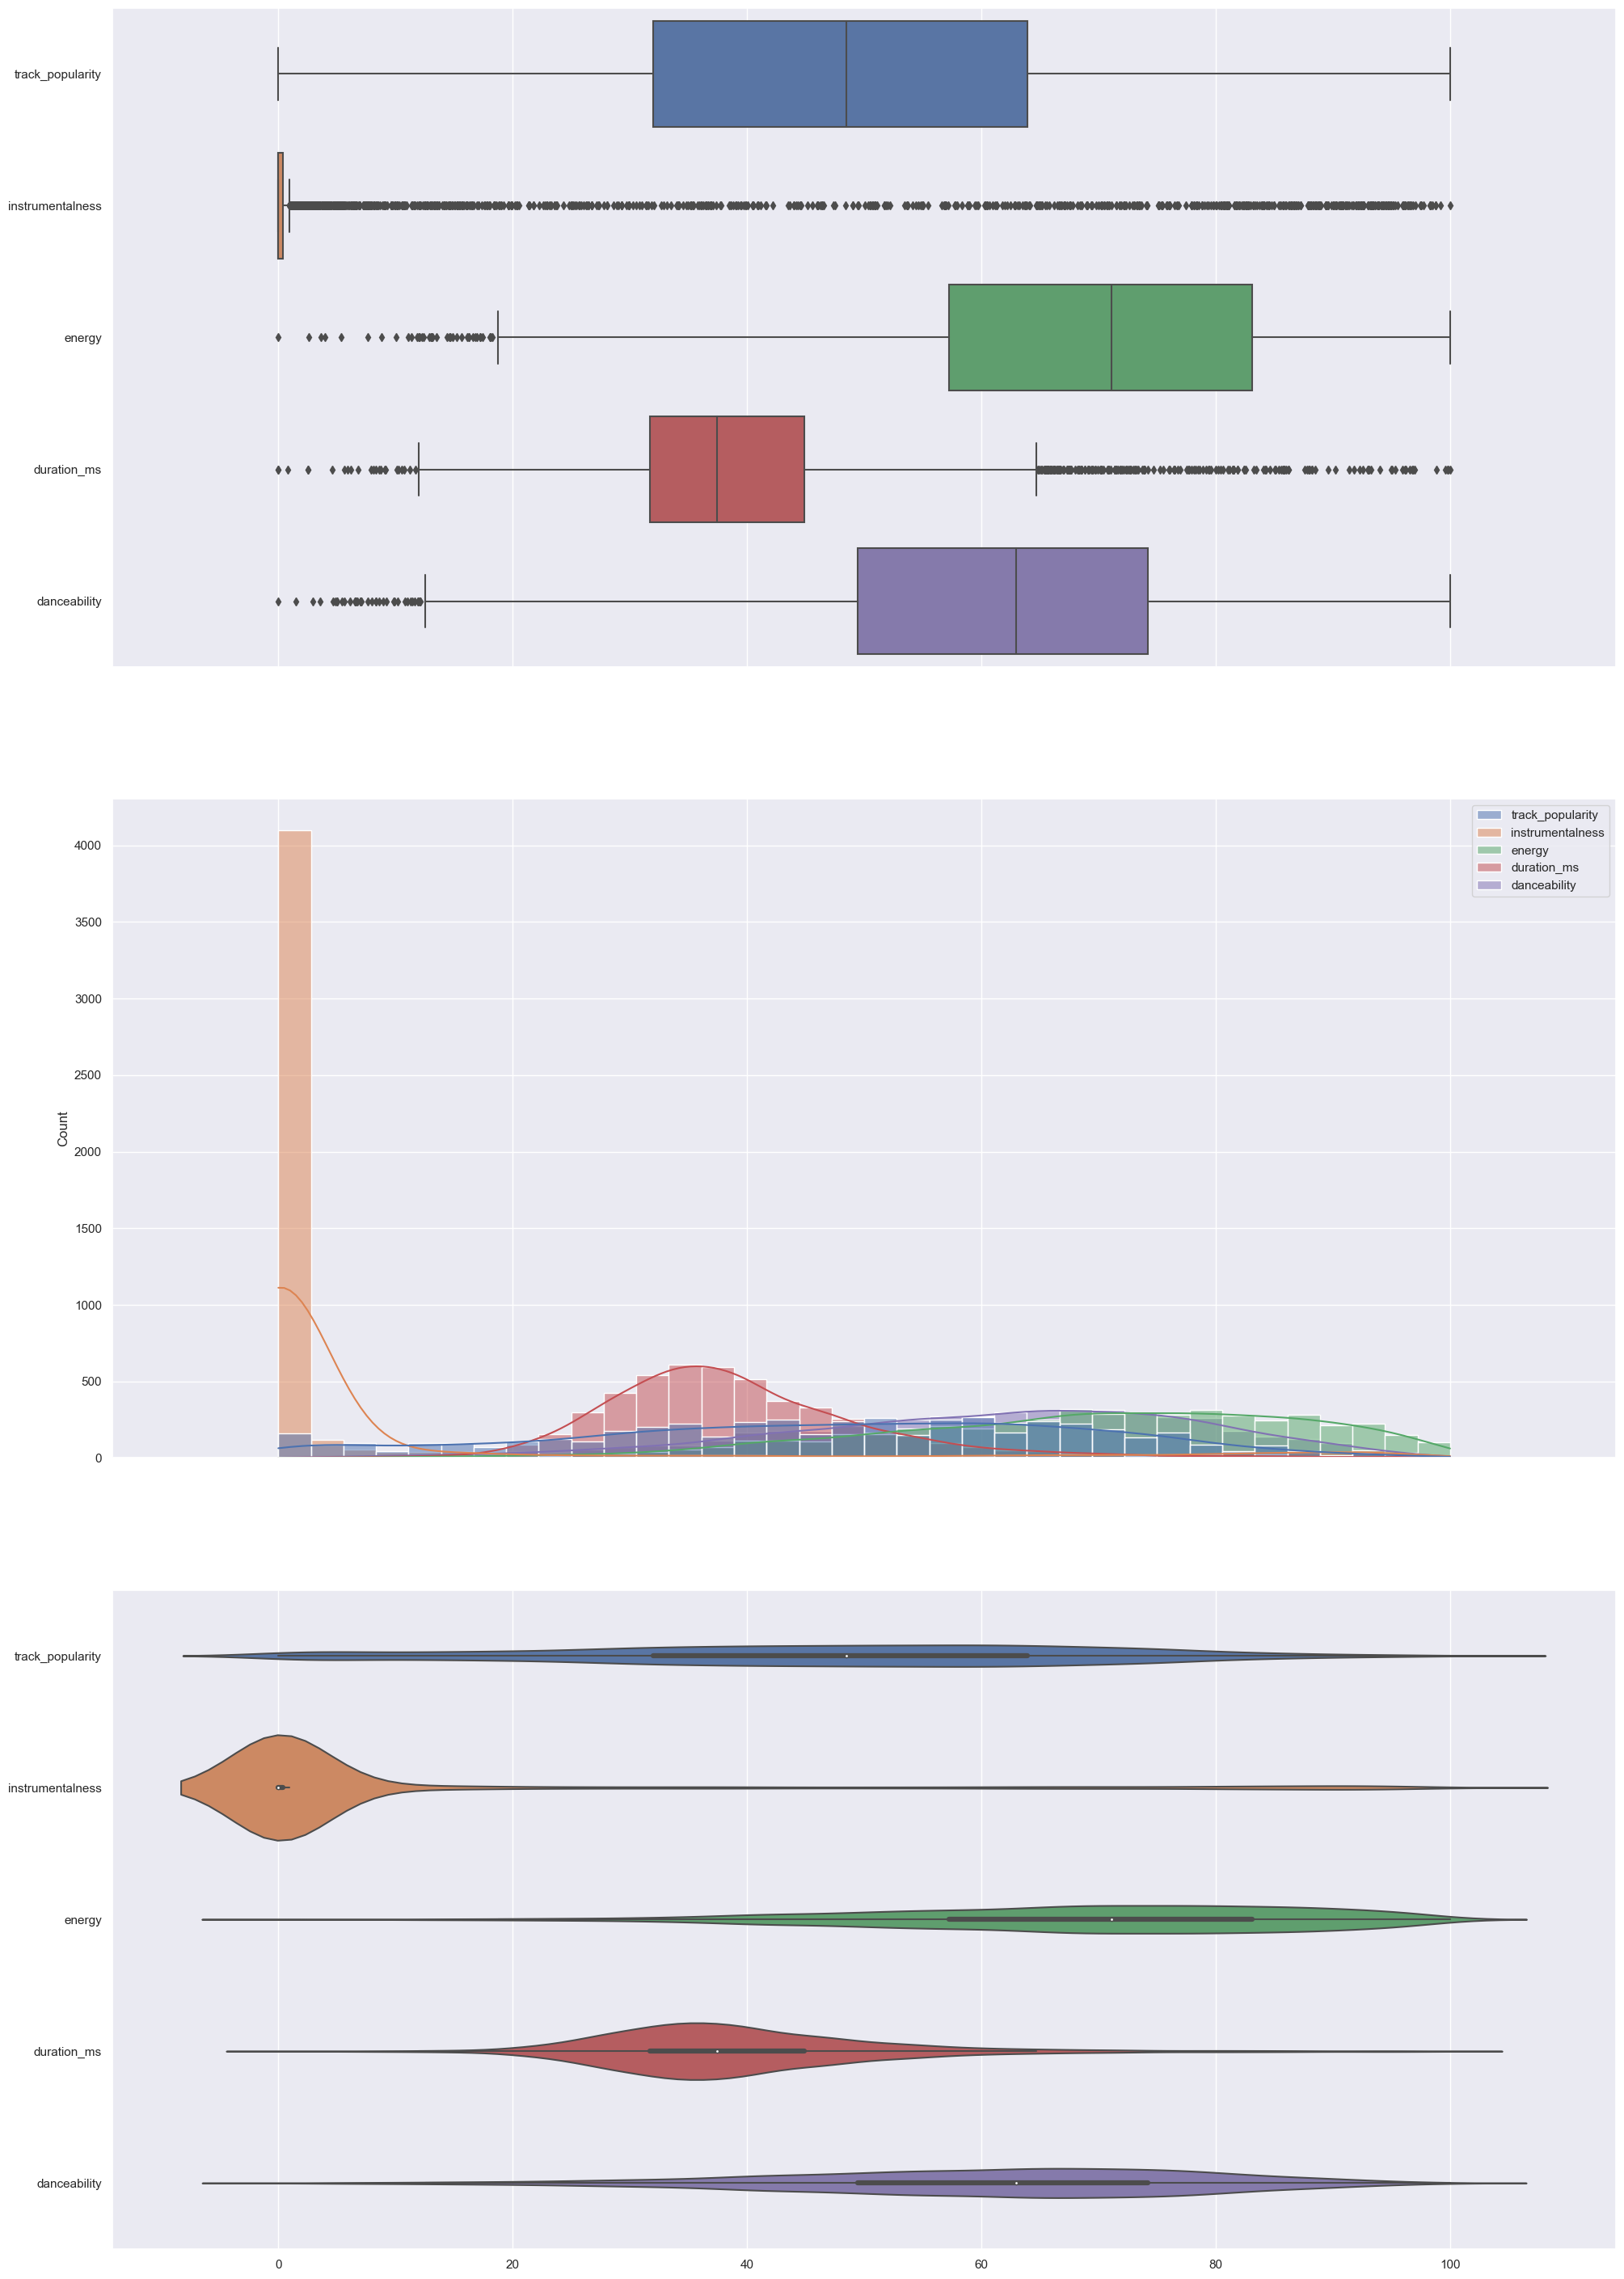

In [29]:
# Plot the correlation matrix and distributions of the four selected variables

def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min()) * 100

numeric5_columns = ["track_popularity", "instrumentalness", "energy", "duration_ms","danceability"]
print(sampled_dataset[numeric5_columns].corr())
sb.heatmap(sampled_dataset[numeric5_columns].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

f, axes = plt.subplots(3, 1, figsize=(24, 36), sharex=True)
sb.boxplot(data = sampled_dataset[numeric5_columns].apply(min_max_normalize), orient = "h", ax=axes[0])
sb.histplot(data = sampled_dataset[numeric5_columns].apply(min_max_normalize), kde = True, ax=axes[1])
sb.violinplot(data = sampled_dataset[numeric5_columns].apply(min_max_normalize), orient = "h", ax=axes[2])

From the KDE plot shown above, we can easily see that the variable `instrumentalness` is not a good variable to be used as a predictor since the graph is severely skewed.

In [30]:
# Print the specific quantitative distribution of instrumentalness
print(sampled_dataset[["instrumentalness"]].describe())
print(sampled_dataset[["instrumentalness"]].value_counts())

       instrumentalness
count       5000.000000
mean           0.082662
std            0.223815
min            0.000000
25%            0.000000
50%            0.000011
75%            0.003595
max            0.979000
instrumentalness
0.000000            1914
0.000012               7
0.011700               7
0.000111               7
0.870000               6
                    ... 
0.000338               1
0.000336               1
0.000335               1
0.000334               1
0.979000               1
Name: count, Length: 2029, dtype: int64


The result above shows that there is a total of **`1914`** records out of `5000` where `instrumentalness == 0`. As there is a serious clustering at the low end, we decide to not use this variable for EDA analysis with `track_popularity`.

                  track_popularity    energy  duration_ms  danceability
track_popularity          1.000000 -0.118293    -0.101557      0.066074
energy                   -0.118293  1.000000    -0.012939     -0.094669
duration_ms              -0.101557 -0.012939     1.000000     -0.089798
danceability              0.066074 -0.094669    -0.089798      1.000000


<Axes: >

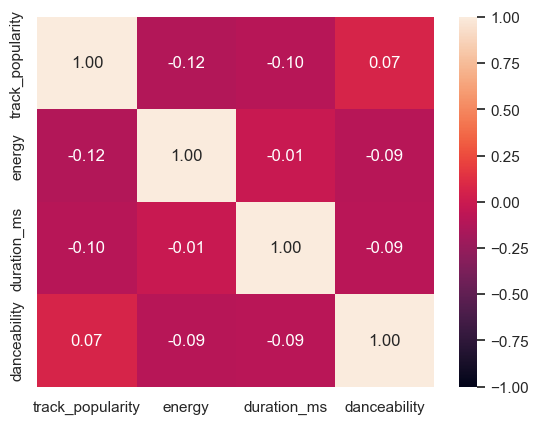

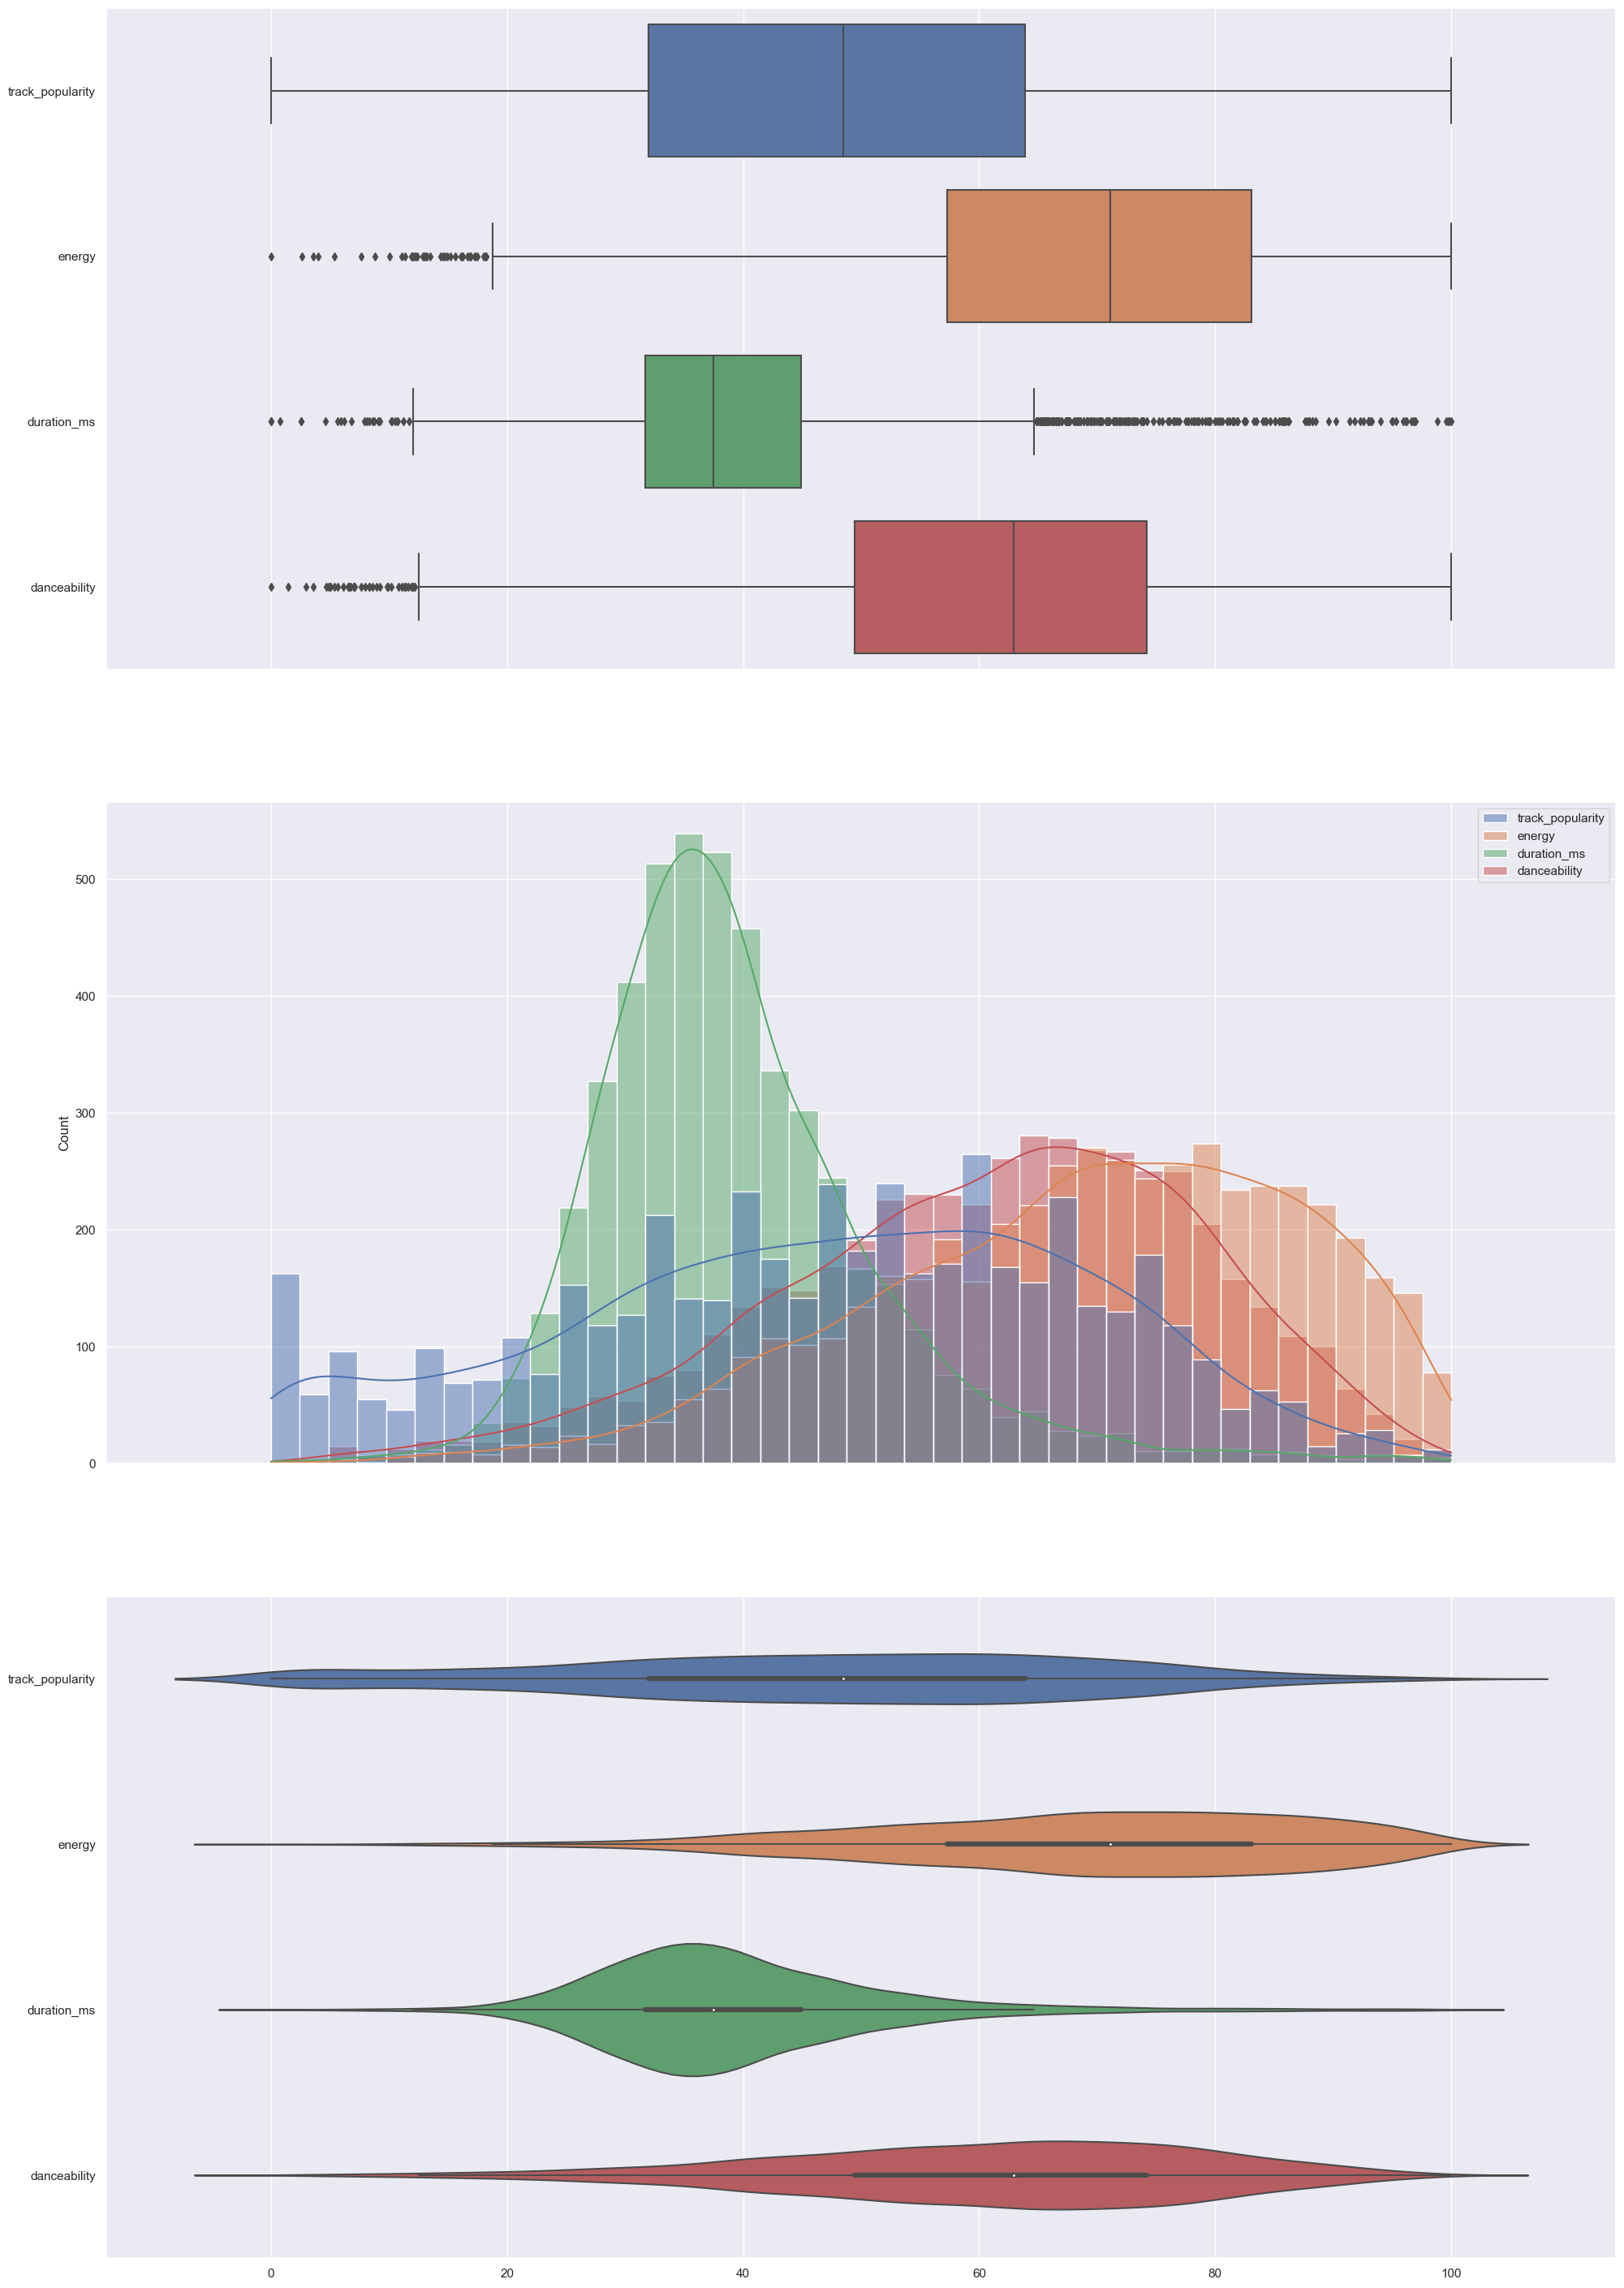

In [31]:
# Plot the correlation matrix and distributions without instrumentalness

def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min()) * 100

# Removed instrumentalness from the numeric column list
numeric4_columns = ["track_popularity", "energy", "duration_ms", "danceability"]
print(sampled_dataset[numeric4_columns].corr())
sb.heatmap(sampled_dataset[numeric4_columns].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

f, axes = plt.subplots(3, 1, figsize=(24, 36), sharex=True)
sb.boxplot(data = sampled_dataset[numeric4_columns].apply(min_max_normalize), orient = "h", ax=axes[0])
sb.histplot(data = sampled_dataset[numeric4_columns].apply(min_max_normalize), kde = True, ax=axes[1])
sb.violinplot(data = sampled_dataset[numeric4_columns].apply(min_max_normalize), orient = "h", ax=axes[2])

### EDA and Visualisation analysis on *categorical* variables

We then examine the *categorical* variables and their relationships with `popularity_level`.

In [32]:
# Check the distribution of the categorical columns
categorical_columns = ["playlist_genre", "playlist_subgenre", "mode", "key"]
sampled_dataset[categorical_columns] = sampled_dataset[categorical_columns].astype('category')
sampled_dataset[categorical_columns].describe()

,playlist_genre,playlist_subgenre,mode,key
count,5000,5000,5000,5000
unique,6,24,2,12
top,edm,progressive electro house,1,1
freq,943,275,2855,638


<Axes: xlabel='playlist_genre', ylabel='popularity_level'>

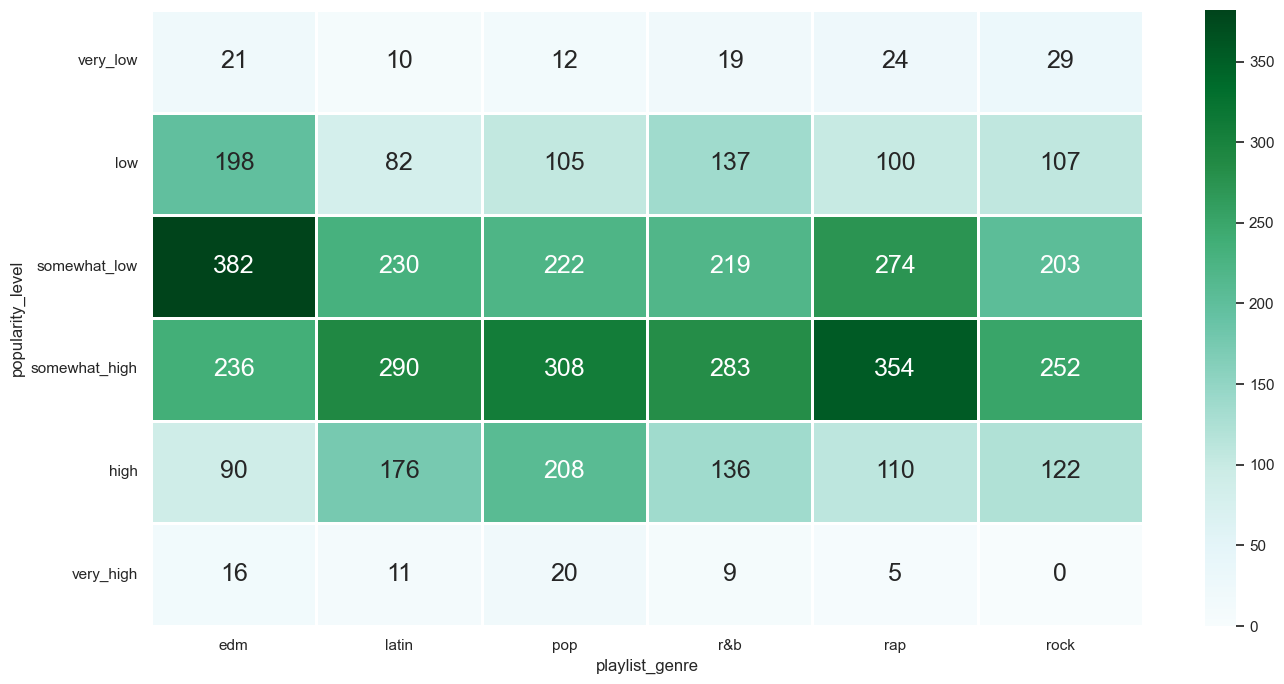

In [33]:
# Relationship of playlist_genre vs popularity_level
f = plt.figure(figsize=(16, 8))
sb.heatmap(sampled_dataset.groupby(['popularity_level', 'playlist_genre']).size().unstack(),
            linewidths=1, annot = True, fmt = 'g', annot_kws={"size": 18}, cmap="BuGn")

<Axes: xlabel='playlist_subgenre', ylabel='popularity_level'>

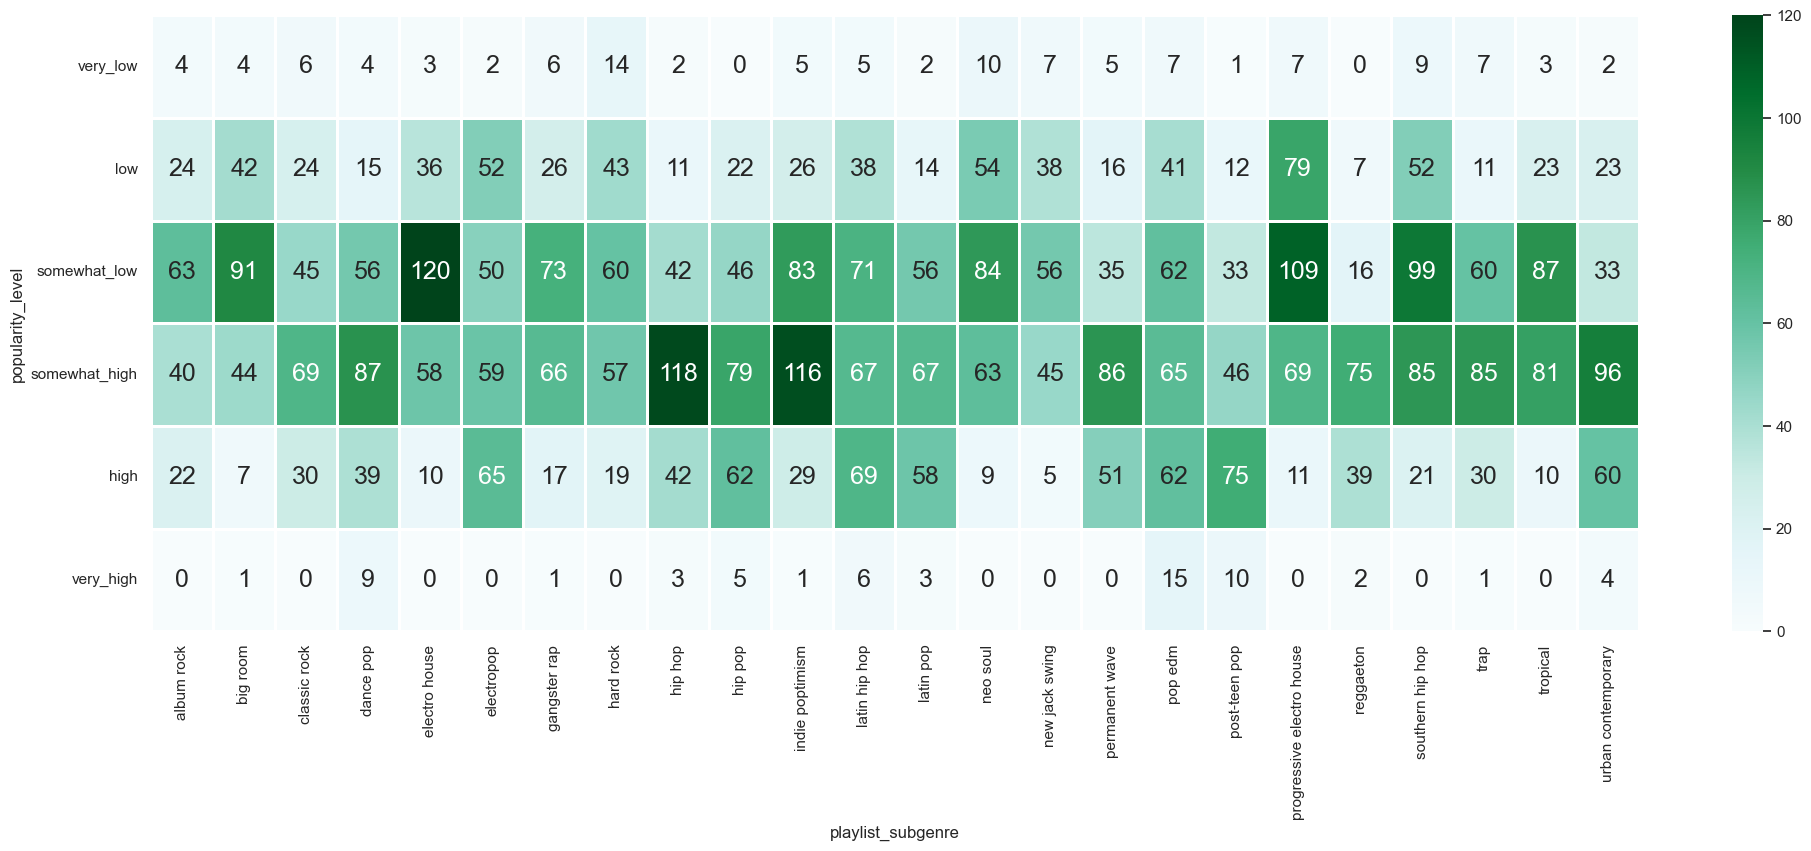

In [34]:
# Relationship of playlist_subgenre vs popularity_level
f = plt.figure(figsize=(24, 8))
sb.heatmap(sampled_dataset.groupby(['popularity_level', 'playlist_subgenre']).size().unstack(),
            linewidths=1, annot = True, fmt = 'g', annot_kws={"size": 18}, cmap="BuGn")

<Axes: xlabel='mode', ylabel='popularity_level'>

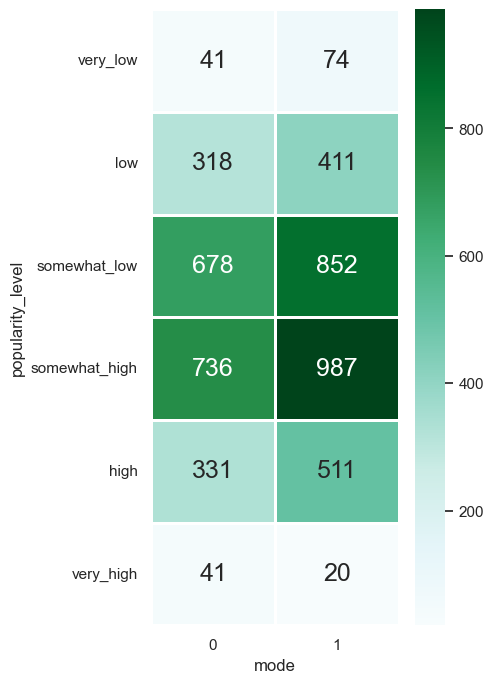

In [35]:
# Relationship of mode vs popularity_level
f = plt.figure(figsize=(4, 8))
sb.heatmap(sampled_dataset.groupby(['popularity_level', 'mode']).size().unstack(),
            linewidths=1, annot = True, fmt = 'g', annot_kws={"size": 18}, cmap="BuGn")

<Axes: xlabel='key', ylabel='popularity_level'>

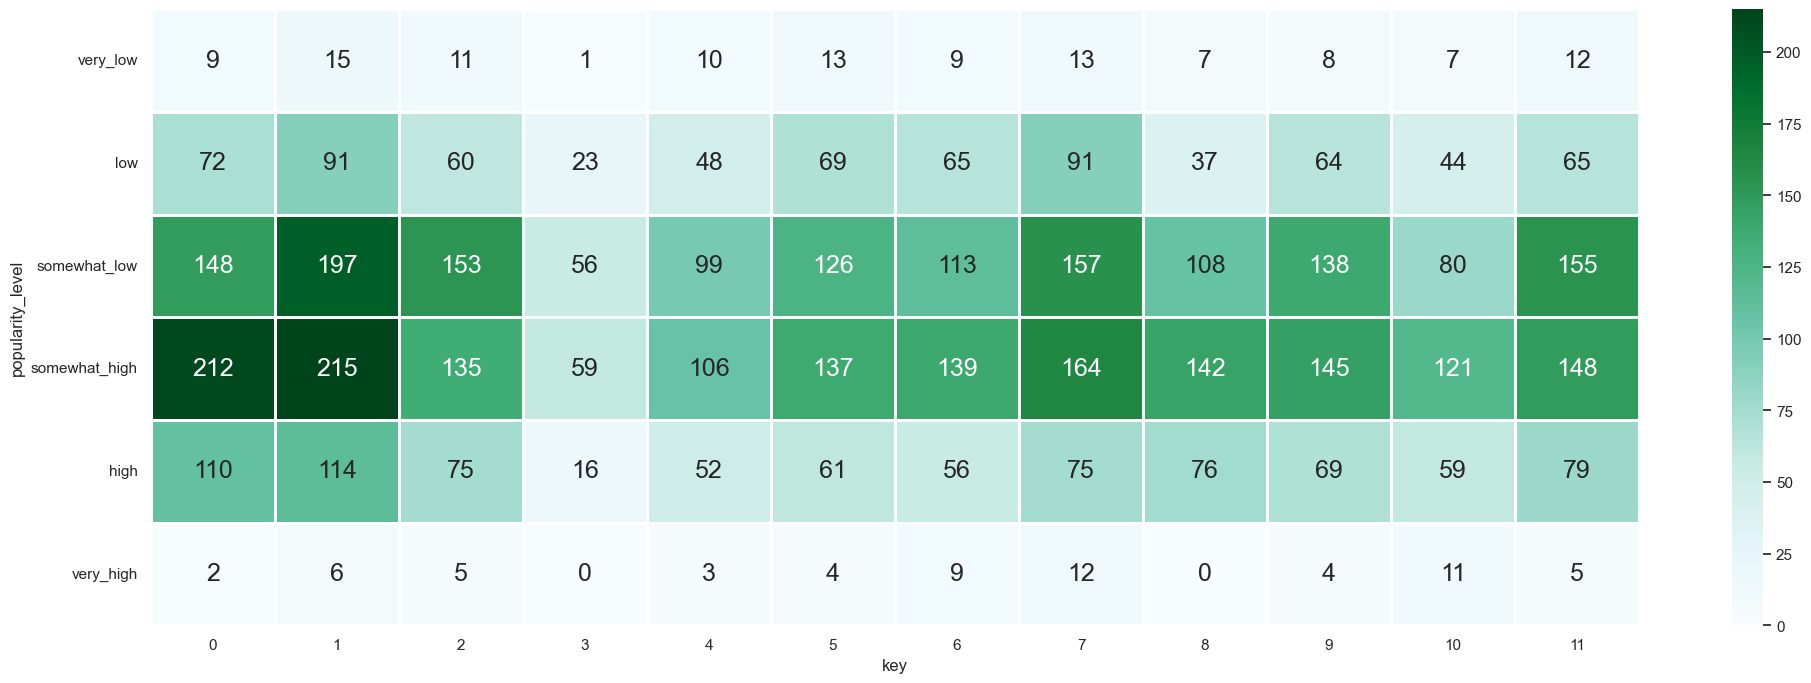

In [36]:
# Relationship of key vs popularity_level
f = plt.figure(figsize=(24, 8))
sb.heatmap(sampled_dataset.groupby(['popularity_level', 'key']).size().unstack(),
            linewidths=1, annot = True, fmt = 'g', annot_kws={"size": 18}, cmap="BuGn")

From the diagrams above, we can see that out of all 4 categorical values listed above, 2 of them (`mode` and `playlist_subgenre`) display some trends that can be used as predictors.

Hence, we will use these two categorical variables and fit them into the models subsequently.

---
## 5. Fitting Model 1 for prediction of popularity_level

In [37]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors
sampled_dataset_cat = sampled_dataset[['mode', 'playlist_subgenre']]
ohe.fit(sampled_dataset_cat)
sampled_dataset_cat_ohe = pd.DataFrame(ohe.transform(sampled_dataset_cat).toarray(), 
                    columns=ohe.get_feature_names_out(sampled_dataset_cat.columns))

# Change indices of the encoded dataset back to the original ones
sampled_dataset_cat_ohe.index = sampled_dataset_cat.index

# Check the encoded variables
sampled_dataset_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 32728 to 1230
Data columns (total 26 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   mode_0                                       5000 non-null   float64
 1   mode_1                                       5000 non-null   float64
 2   playlist_subgenre_album rock                 5000 non-null   float64
 3   playlist_subgenre_big room                   5000 non-null   float64
 4   playlist_subgenre_classic rock               5000 non-null   float64
 5   playlist_subgenre_dance pop                  5000 non-null   float64
 6   playlist_subgenre_electro house              5000 non-null   float64
 7   playlist_subgenre_electropop                 5000 non-null   float64
 8   playlist_subgenre_gangster rap               5000 non-null   float64
 9   playlist_subgenre_hard rock                  5000 non-null   float64
 10  p

In [38]:
# Combining Numeric features with the OHE Categorical features
sampled_dataset_num = sampled_dataset[["energy", "duration_ms", "danceability"]]
sampled_dataset_res = sampled_dataset["popularity_level"]
sampled_dataset_ohe = pd.concat([sampled_dataset_num, sampled_dataset_cat_ohe, sampled_dataset_res], 
                                  sort = False, axis = 1).reindex(index=sampled_dataset_res.index)

# Check the final DataFrame
sampled_dataset_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 32728 to 1230
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   energy                                       5000 non-null   float64 
 1   duration_ms                                  5000 non-null   int64   
 2   danceability                                 5000 non-null   float64 
 3   mode_0                                       5000 non-null   float64 
 4   mode_1                                       5000 non-null   float64 
 5   playlist_subgenre_album rock                 5000 non-null   float64 
 6   playlist_subgenre_big room                   5000 non-null   float64 
 7   playlist_subgenre_classic rock               5000 non-null   float64 
 8   playlist_subgenre_dance pop                  5000 non-null   float64 
 9   playlist_subgenre_electro house              5000 non-null   flo

### Create and Fit the Model

[Text(0.5431034482758621, 0.9, 'playlist_subgenre_post-teen pop <= 0.5\ngini = 0.738\nsamples = 3500\nvalue = [586, 525, 1188, 1082, 43, 76]\nclass = Somewhat Low'),
 Text(0.27586206896551724, 0.7, 'playlist_subgenre_progressive electro house <= 0.5\ngini = 0.736\nsamples = 3390\nvalue = [532, 520, 1162, 1062, 38, 76]\nclass = Somewhat Low'),
 Text(0.13793103448275862, 0.5, 'playlist_subgenre_electro house <= 0.5\ngini = 0.735\nsamples = 3203\nvalue = [524, 465, 1122, 981, 38, 73]\nclass = Somewhat Low'),
 Text(0.06896551724137931, 0.3, 'playlist_subgenre_big room <= 0.5\ngini = 0.736\nsamples = 3046\nvalue = [519, 437, 1083, 898, 38, 71]\nclass = Somewhat Low'),
 Text(0.034482758620689655, 0.1, 'gini = 0.736\nsamples = 2917\nvalue = [514, 408, 1056, 833, 38, 68]\nclass = Somewhat Low'),
 Text(0.10344827586206896, 0.1, 'gini = 0.65\nsamples = 129\nvalue = [5, 29, 27, 65, 0, 3]\nclass = Somewhat High'),
 Text(0.20689655172413793, 0.3, 'duration_ms <= 133274.0\ngini = 0.626\nsamples = 15

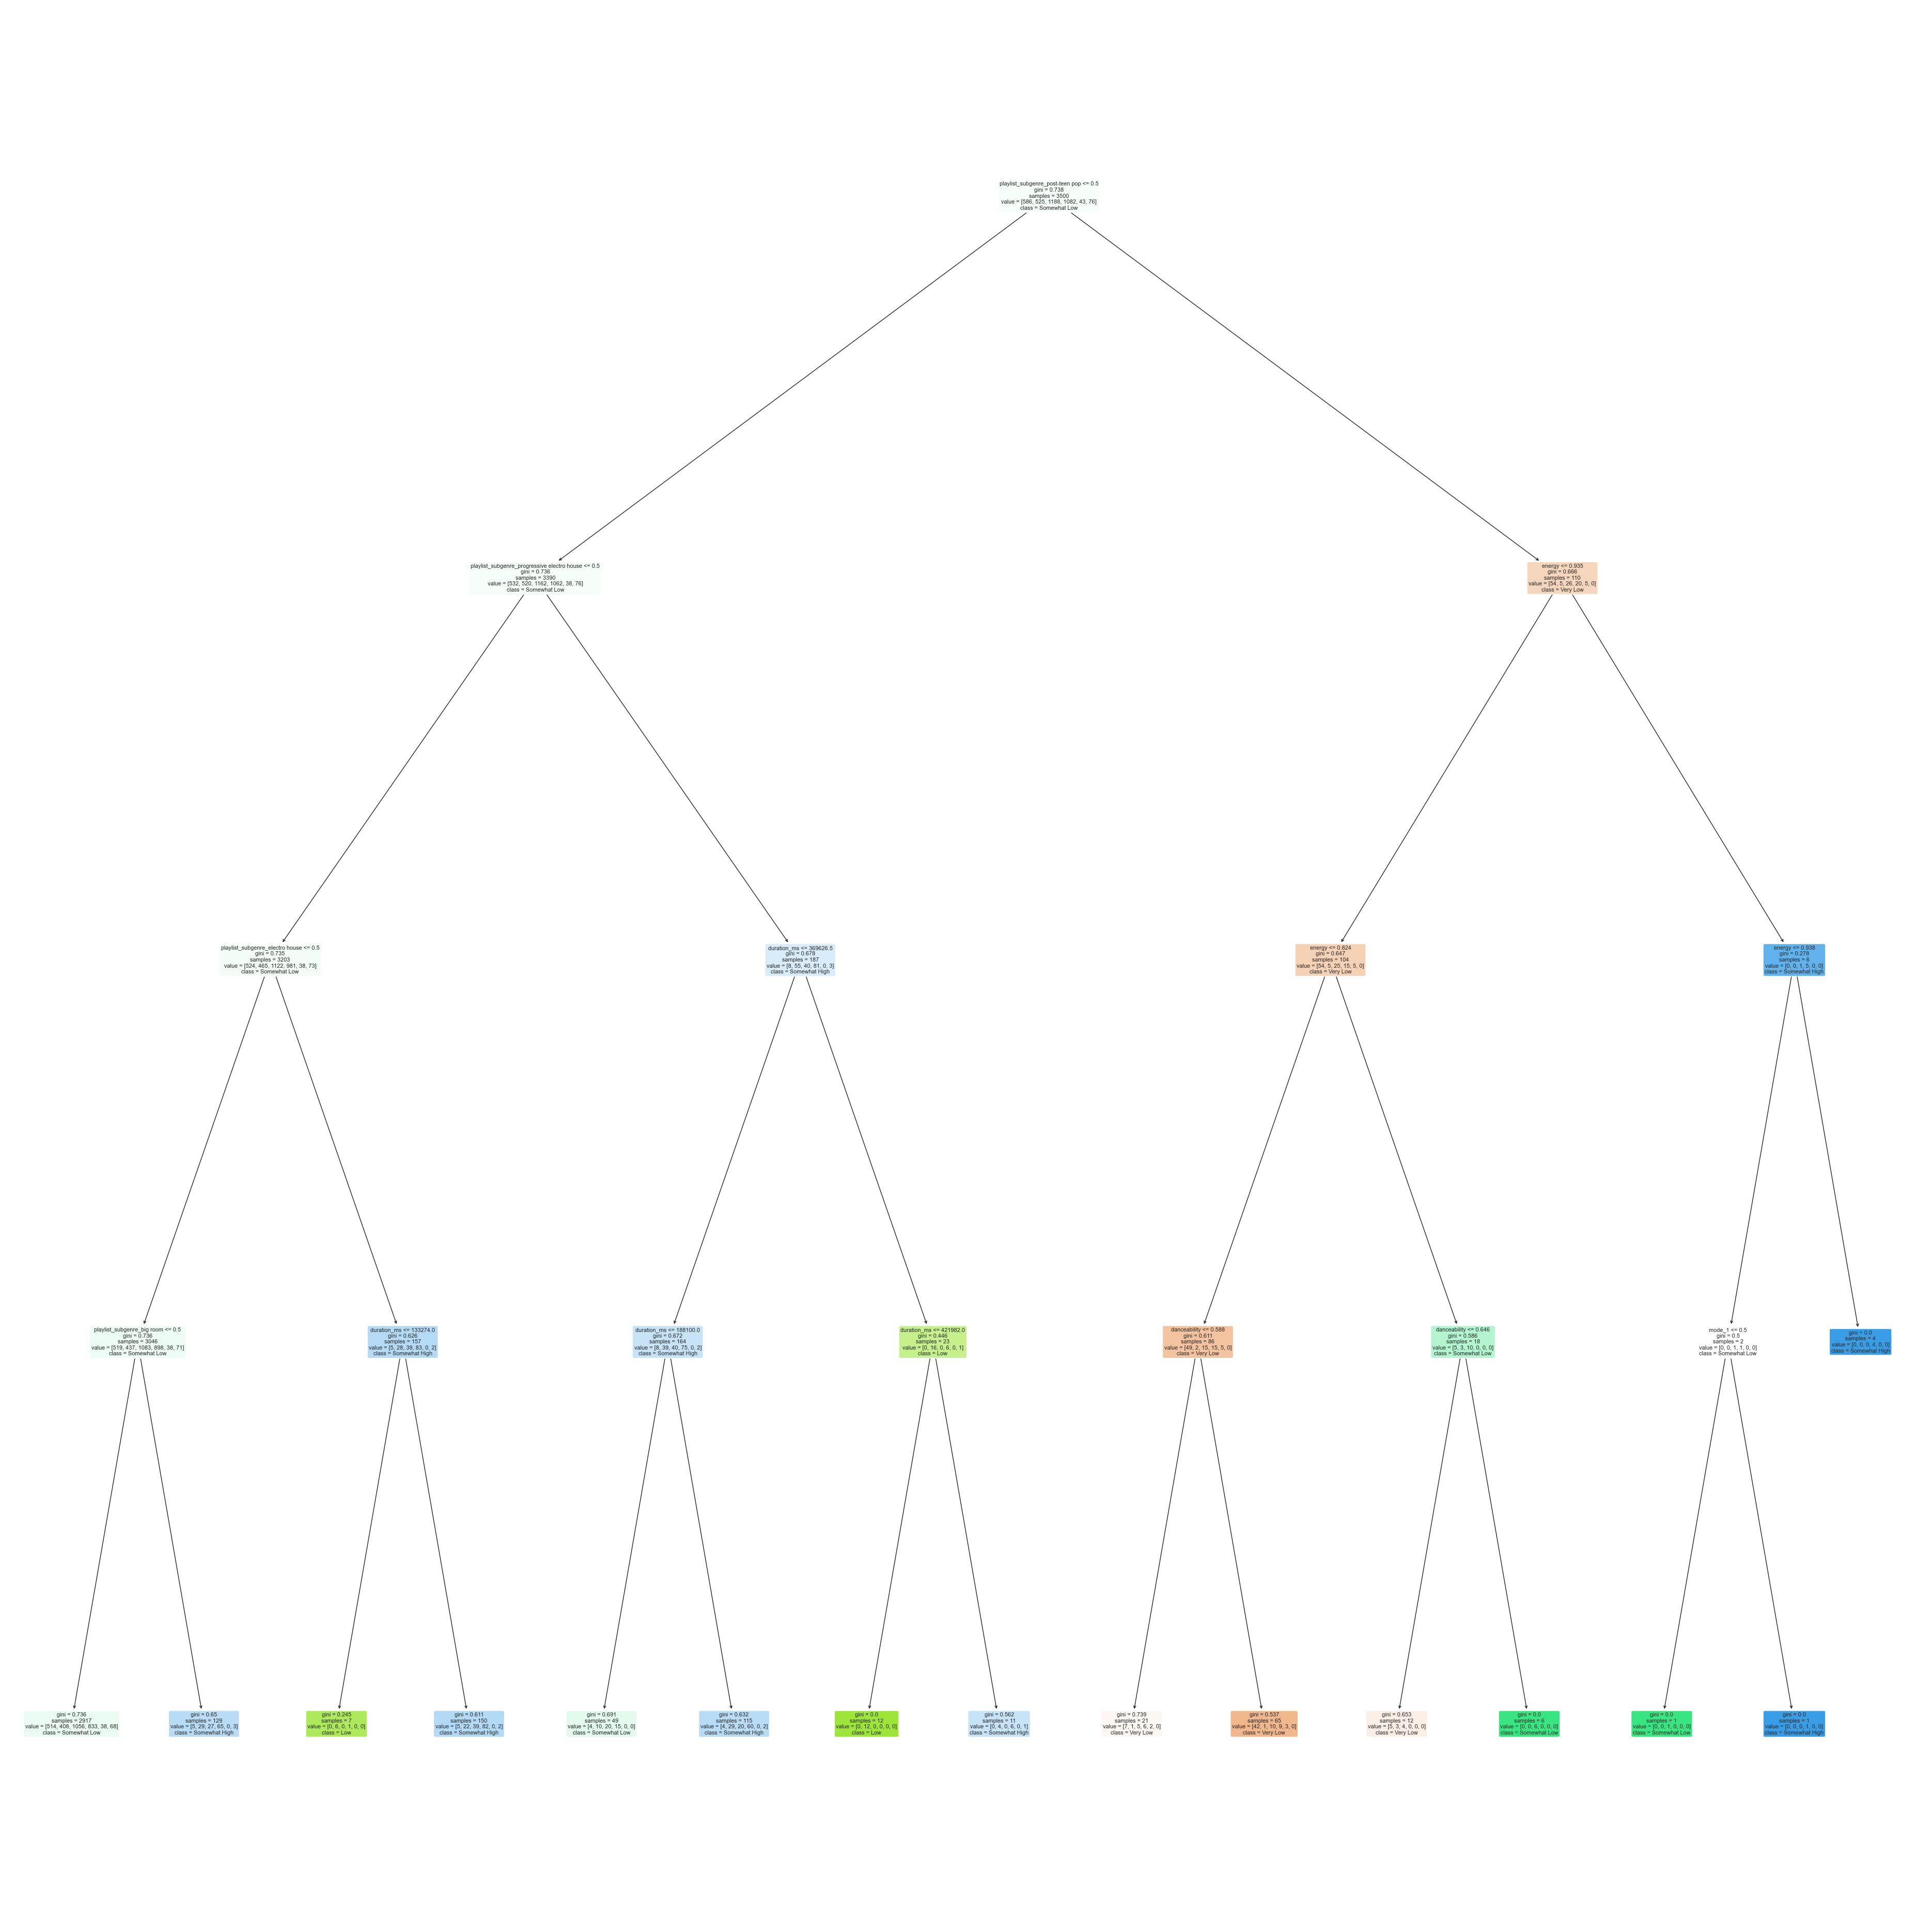

In [39]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(sampled_dataset_ohe['popularity_level'])
X = pd.DataFrame(sampled_dataset_ohe.drop('popularity_level', axis = 1))

# Split the Dataset into Train and Test with a fixed random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 17)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(48,48))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=list(X_train.columns),
          class_names=["Very Low", "Low", "Somewhat Low", "Somewhat High", "High", "Very High"])

### Check the accuracy of the Model

Train Data
Accuracy  :	 0.3922857142857143

Train Accuracy and Error rates:
     Very Low       Low  Somewhat Low  Somewhat High  High  Very High
TPR   0.09215  0.034286      0.911616       0.201479   0.0        0.0
TNR   0.98490  0.999664      0.182526       0.920596   1.0        1.0
FPR   0.01510  0.000336      0.817474       0.079404   0.0        0.0
FNR   0.90785  0.965714      0.088384       0.798521   1.0        1.0


<Axes: >

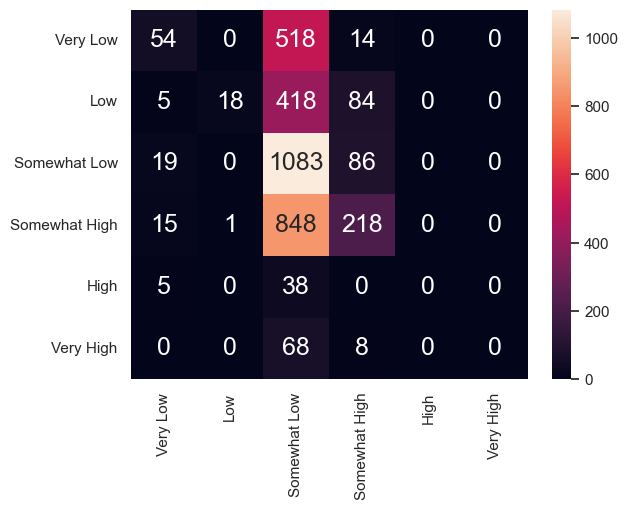

In [40]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
fpTrain = (cmTrain.sum(axis=0) - np.diag(cmTrain))
fnTrain = (cmTrain.sum(axis=1) - np.diag(cmTrain))
tpTrain = np.diag(cmTrain)
tnTrain = cmTrain.sum() - (fpTrain + fnTrain + tpTrain)
train_rates = pd.DataFrame(np.array([
                        (tpTrain/(tpTrain + fnTrain)),
                        (tnTrain/(tnTrain + fpTrain)),
                        (fpTrain/(tnTrain + fpTrain)),
                        (fnTrain/(tpTrain + fnTrain))
                     ]),
                     index = ["TPR", "TNR", "FPR", "FNR"],
                     columns = ["Very Low", "Low", "Somewhat Low", "Somewhat High", "High", "Very High"])
print("Train Accuracy and Error rates:")
print(train_rates)

# Plot the two-way Confusion Matrix
sb.heatmap(cmTrain, annot = True, fmt=".0f", annot_kws={"size": 18},
           xticklabels = ["Very Low", "Low", "Somewhat Low", "Somewhat High", "High", "Very High"],
           yticklabels = ["Very Low", "Low", "Somewhat Low", "Somewhat High", "High", "Very High"])

Test Data
Accuracy  :	 0.37666666666666665

Test Accuracy and Error rates:
     Very Low       Low  Somewhat Low  Somewhat High  High  Very High
TPR  0.070312  0.004902      0.872897       0.176339   0.0        0.0
TNR  0.969453  0.995370      0.188601       0.897338   1.0        1.0
FPR  0.030547  0.004630      0.811399       0.102662   0.0        0.0
FNR  0.929688  0.995098      0.127103       0.823661   1.0        1.0


<Axes: >

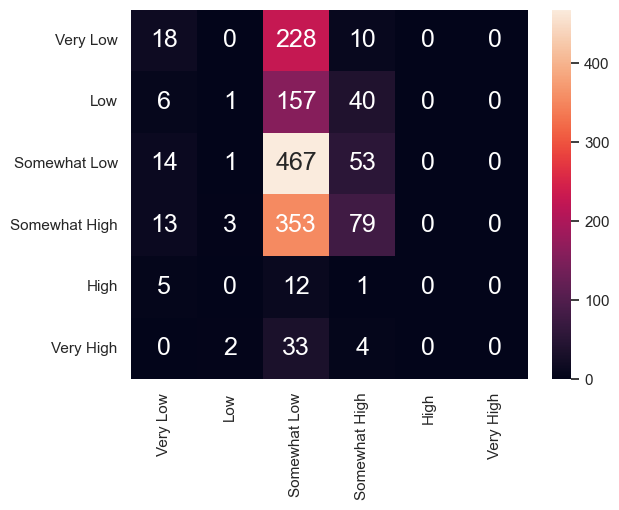

In [41]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
fpTest = (cmTest.sum(axis=0) - np.diag(cmTest))
fnTest = (cmTest.sum(axis=1) - np.diag(cmTest))
tpTest = np.diag(cmTest)
tnTest = cmTest.sum() - (fpTest + fnTest + tpTest)
test_rates = pd.DataFrame(np.array([
                        (tpTest/(tpTest + fnTest)),
                        (tnTest/(tnTest + fpTest)),
                        (fpTest/(tnTest + fpTest)),
                        (fnTest/(tpTest + fnTest))
                     ]),
                     index = ["TPR", "TNR", "FPR", "FNR"],
                     columns = ["Very Low", "Low", "Somewhat Low", "Somewhat High", "High", "Very High"])
print("Test Accuracy and Error rates:")
print(test_rates)

# Plot the two-way Confusion Matrix
sb.heatmap(cmTest, annot = True, fmt=".0f", annot_kws={"size": 18},
           xticklabels = ["Very Low", "Low", "Somewhat Low", "Somewhat High", "High", "Very High"],
           yticklabels = ["Very Low", "Low", "Somewhat Low", "Somewhat High", "High", "Very High"])

### Reflection for Refinement

Current issue: While TNR is desirably high, the value of TPR is relatiely low. This means that there are many missed positive cases as a low TPR indicated that a significant number of actual positive cases are being missed by the model, resulting in high false negatives from the sample. This is the direct result from the model having low accuracy rate on the test data sample.

Solution: In order to resolve the problem and refine our model, we decide to decrease the number of popularity_levels from the current 6 levels to 3 levels, namely: high, medium and low. The levels are defined as follows: high (track_popularity > mean+sd), medium (mean-sd <= track_popularity <= mean+sd), (track_popularity < mean-sd). By lowering the number of levels, we hope to achieve higher accuracy rate.

In [42]:
# Check the ratio between the High "family" and Low "family" categories in popularity_level
popularity_level_counts = sampled_dataset["popularity_level"].value_counts(sort=False)
low_popularity_level_count = popularity_level_counts[:3].sum()
high_popularity_level_count = popularity_level_counts[3:].sum()
print("Ratio of popularitylevel:")
print("High \"family\" : Low \"family\" =", high_popularity_level_count, ":", low_popularity_level_count)

Ratio of popularitylevel:
High "family" : Low "family" = 2626 : 2374
